In [ ]:
# | default_exp analyses.order_error_rate
%load_ext autoreload
%autoreload 2

# Order Error Rate

In [ ]:
# | export

from typing import Optional, Sequence

import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
from matplotlib import rcParams  # type: ignore
from matplotlib.axes import Axes

from jaxcmr.helpers import apply_by_subject, find_max_list_length
from jaxcmr.repetition import all_study_positions
from jaxcmr.plotting import init_plot, plot_data, set_plot_labels
from jaxcmr.typing import Array, Bool, Float, Integer, RecallDataset


## Calculation

In [ ]:
# | exports

def trial_order_error_rate(
    recalls: Integer[Array, " recall_positions"],
    presentations: Integer[Array, " study_positions"],
    size: int = 3,
) -> Bool[Array, " study_positions"]:
    """
    One Boolean per study slot:
        True  → an item from the list was reported in output slot *i*,
                but that item does *not* belong to this study position.
        False → correct, omission, intrusion, or padded study slot.
    """

    list_len = presentations.shape[0]
    study_pos_1 = jnp.arange(1, list_len + 1)          # 1-based indexes

    # 1. Token produced at each output slot i (pad with 0 if recall shorter)
    recall_tokens = jnp.where(
        study_pos_1 - 1 < recalls.shape[0],   # convert to 0-based for slicing
        recalls[:list_len],
        0,                                    # no response → treat as 0
    )

    # 2. Is that token on today’s list (and non-zero)?
    #    token k is "on the list" if 1 ≤ k ≤ list_len and presentations[k-1] ≠ 0
    token_on_list = (
        (recall_tokens > 0)
        & (recall_tokens <= list_len)
        & (presentations[recall_tokens - 1] != 0)
    )

    # 3. For each output slot, does its token actually belong here?
    #    Use all_study_positions to map token → all study slots of that item.
    expanded = vmap(all_study_positions, in_axes=(0, None, None))(
        recall_tokens, presentations, size
    )                          # shape: (list_len, size)

    correct_here = jnp.any(expanded == study_pos_1[:, None], axis=1)

    # 4. Order-error logic, ignoring padded study slots (presentations == 0)
    return token_on_list & (~correct_here) & (presentations != 0)

def order_error_rate(
    recalls: Integer[Array, " trial_count recall_positions"],
    presentations: Integer[Array, " trial_count study_positions"],
    list_length: int,
    size: int = 3,
) -> Float[Array, " study_positions"]:
    """
    Returns position-specific recall accuracy, not assuming uniform study lists.

    Args:
        recalls: trial by recall position array of recalled items. 1-indexed; 0 for no recall.
        presentations: trial by study position array of presented items. 1-indexed.
        size: the number of studied items in each trial.
    """
    return vmap(trial_order_error_rate, in_axes=(0, 0, None))(
        recalls,
        presentations,
        size,
    ).mean(axis=0)

## Plotting

In [ ]:
# | exports


def plot_order_error_rate(
    datasets: Sequence[RecallDataset] | RecallDataset,
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
) -> Axes:
    """
    Plots serial recall accuracy curve for one or more datasets.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.

    Returns:
        The matplotlib Axes object containing the plot.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [c["color"] for c in rcParams["axes.prop_cycle"]]

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    if labels is None:
        labels = ["" for _ in datasets]

    # Identify the largest list length across datasets, so we can plot consistently
    max_list_length = find_max_list_length(datasets, trial_masks)

    for data_index, data_dict in enumerate(datasets):
        subject_values = jnp.vstack(
            apply_by_subject(
                data_dict,
                trial_masks[data_index],
                jit(order_error_rate),
            )
        )

        # Plot
        color = color_cycle.pop(0)
        subject_values = subject_values[:, :max_list_length]
        xvals = jnp.arange(max_list_length) + 1
        plot_data(axis, xvals, subject_values, labels[data_index], color)

    set_plot_labels(axis, "Study Position", "Serial Recall Accuracy", contrast_name)
    return axis

## Tests

In [ ]:

# 1. perfect recall
def test_order_study_all_correct():
    pres = jnp.array([[1, 2, 3]])
    rec  = jnp.array([[1, 2, 3]])
    exp  = jnp.array([False, False, False])
    assert jnp.array_equal(trial_order_error_rate(rec[0], pres[0]), exp)


# 2. simple swap
def test_order_study_simple_swap():
    pres = jnp.array([[1, 2, 3]])
    rec  = jnp.array([[1, 3, 2]])
    exp  = jnp.array([False, True, True])
    assert jnp.array_equal(trial_order_error_rate(rec[0], pres[0]), exp)


# 3. intrusion does NOT count as order error
def test_order_study_intrusion_not_error():
    pres = jnp.array([[1, 2, 3]])
    rec  = jnp.array([[1, -1, 2]])          # slot-2 = omission/intrusion code 0
    exp  = jnp.array([False, False, True]) # only slot-3 is order error
    assert jnp.array_equal(trial_order_error_rate(rec[0], pres[0]), exp)


# 4. repeated study items
def test_order_study_with_repeats():
    pres = jnp.array([[1, 1, 2]])
    rec  = jnp.array([[1, 3, 0]])          # token 3 mis-places item 2 at slot-2
    exp  = jnp.array([False, True, False])
    assert jnp.array_equal(trial_order_error_rate(rec[0], pres[0]), exp)


# 5. extra output slots are outside study list → ignore
def test_order_study_ignore_extra_outputs():
    pres = jnp.array([[1, 2, 3]])
    rec  = jnp.array([[1, 2, 3, 2]])       # 4th output analysed elsewhere
    exp  = jnp.array([False, False, False])  # only first three slots returned
    assert jnp.array_equal(trial_order_error_rate(rec[0], pres[0]), exp)


# run battery
test_order_study_all_correct()
test_order_study_simple_swap()
test_order_study_intrusion_not_error()
test_order_study_with_repeats()
test_order_study_ignore_extra_outputs()

## Examples

With real data, we would typically have a dictionary containing:
- `recalls`: a [trials x possibly_many_output_positions] array
- `pres_itemnos`: a [trials x list_length] array

Then we can use the provided plotting function to visualize position-wise accuracy for different conditions.

In [ ]:
import os

from jaxcmr.helpers import find_project_root, generate_trial_mask, load_data

/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


Array([0.78333336, 0.8309524 , 0.87857145, 0.8952381 , 0.90000004,
       0.86428577, 0.82380956, 0.7904762 , 0.7285715 , 0.6642857 ,
       0.6238096 , 0.5761905 , 0.5214286 , 0.4761905 , 0.42857143,
       0.3904762 , 0.35714287, 0.3214286 , 0.27857143, 0.23809525,
       0.19285715, 0.15238096, 0.12857144, 0.08571429, 0.07619048,
       0.05714286, 0.05      , 0.03571429, 0.02857143, 0.02380952,
       0.01666667, 0.01666667, 0.01428572, 0.00952381, 0.00714286,
       0.00238095, 0.00238095, 0.        , 0.        , 0.        ],      dtype=float32)

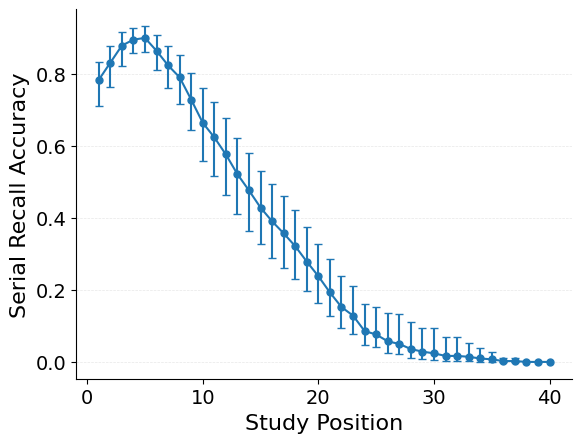

In [ ]:
# parameters
run_tag = "SRAC"
data_query = "data['list_type'] == 1"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot
plot_order_error_rate(data, generate_trial_mask(data, data_query))
jit(order_error_rate)(recalls[trial_mask], presentations[trial_mask], list_length)

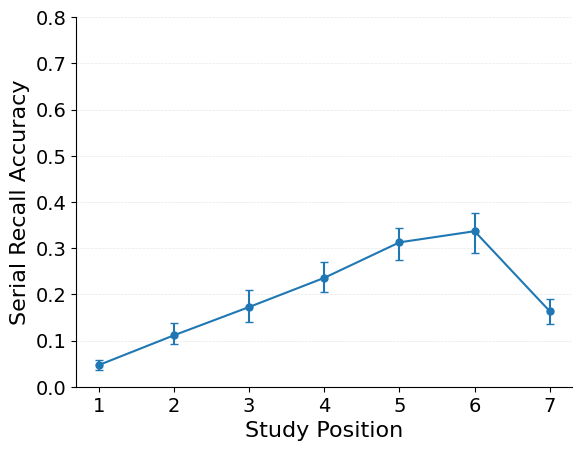

In [ ]:
# parameters
data_name = "Gordon2021"
data_query = "jnp.logical_and(data['condition'] == 2, data['listLength'] == 7)"
# data_query = "data['condition'] == 2"
data_path = os.path.join(find_project_root(), "data/Gordon2021.h5")

# set up data structures
data = load_data(data_path)
arr = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot
plot_order_error_rate(data, generate_trial_mask(data, data_query))
order_error_rate(arr[trial_mask], presentations[trial_mask], list_length)
plt.ylim(0, .8);

Array([0.02256944, 0.05164931, 0.06901041, 0.07986111, 0.09375   ,
       0.04340278], dtype=float32)

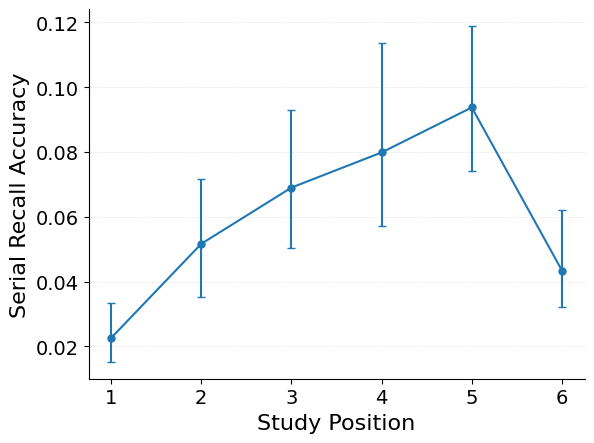

In [ ]:
# parameters
run_tag = "SRAC"
data_name = "GordonRanschburg2021"
data_query = "jnp.logical_and(data['condition'] == 1, data['lag'] != 4)"
# data_query = "data['condition'] == 2"
data_path = os.path.join(find_project_root(), "data/GordonRanschburg2021.h5")

# set up data structures
data = load_data(data_path)
arr = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot SPC
plot_order_error_rate(data, generate_trial_mask(data, data_query))
order_error_rate(arr[trial_mask], presentations[trial_mask], list_length)
# plt.ylim(0, 1);

data/KahanaJacobs2000.h5
[0.19736843 0.2631579  0.28508773 0.34649122 0.36842105 0.32894737
 0.34210527 0.2631579  0.21052632 0.16228071 0.14473684 0.10526316
 0.03070175]


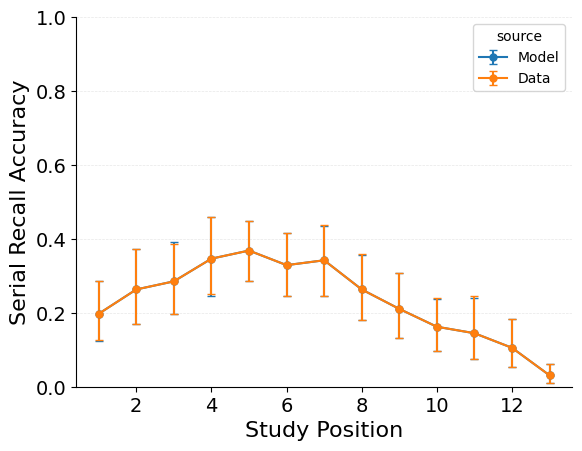

fits/KahanaJacobs2000_WeirdCMR_full_best_of_3.h5
[0.00889908 0.06045872 0.11706422 0.16605504 0.21743119 0.25688073
 0.2887156  0.29477063 0.28266054 0.24706422 0.19733945 0.12238532
 0.05715596]


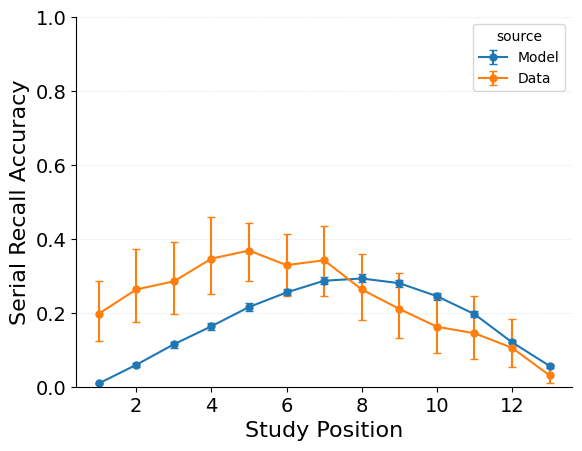

fits/KahanaJacobs2000_WeirdNoReinstateCMR_full_best_of_3.h5
[0.00889908 0.05220183 0.10183486 0.14963302 0.20238532 0.24348623
 0.27678898 0.28816512 0.27366972 0.2366055  0.18761468 0.11678899
 0.05614679]


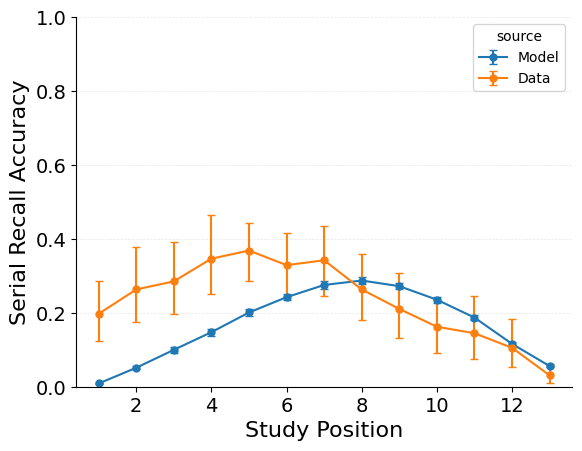

fits/KahanaJacobs2000_WeirdPositionScaleCMR_full_best_of_3.h5
[0.01394495 0.05724771 0.10605504 0.15577981 0.21009174 0.2559633
 0.2925688  0.30431193 0.29110092 0.2522936  0.19706422 0.11935779
 0.05073394]


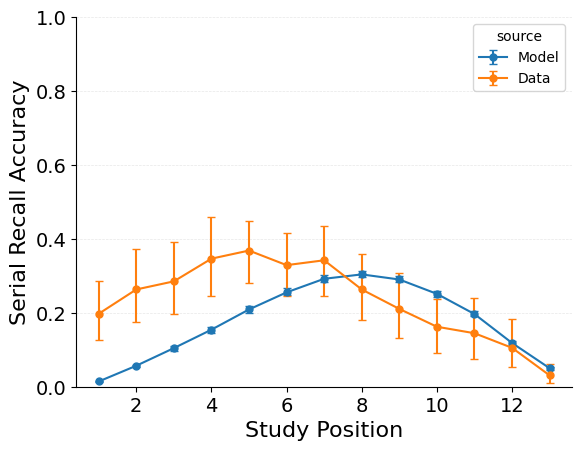

fits/KahanaJacobs2000_OutlistCMRDE_full_best_of_3.h5
[0.00954128 0.04825688 0.09926605 0.14954127 0.20366973 0.24834862
 0.28311926 0.29366973 0.28146788 0.24422018 0.19201834 0.1119266
 0.04550458]


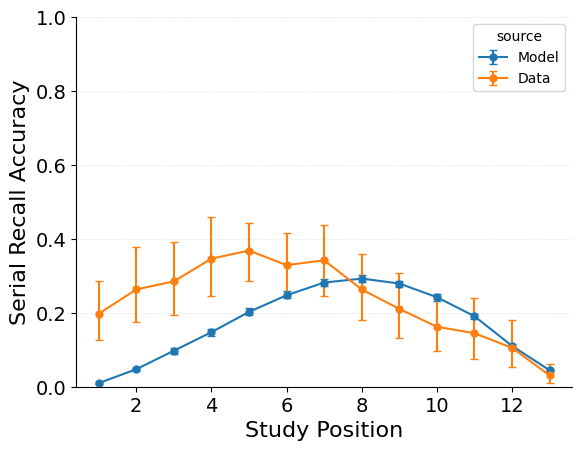

fits/KahanaJacobs2000_WeirdDriftPositionScaleCMR_full_best_of_3.h5
[0.34266055 0.63284403 0.75522935 0.79889905 0.8006422  0.7740367
 0.7246789  0.6611009  0.56697243 0.4606422  0.34412843 0.20339449
 0.09045871]


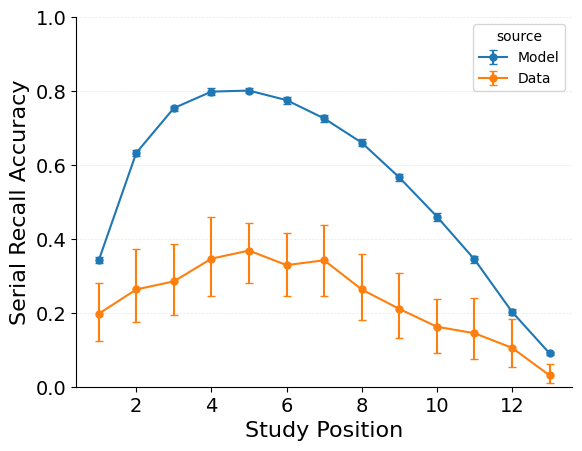

In [ ]:
# parameters
data_query = "jnp.logical_and(jnp.logical_and(jnp.logical_and(data['recall_attempt'] == 1, data['repetitions'] == 0), data['session'] <= 2), data['listLength'] == 13)"
# redo data query just using recall_attempt <= 2
run_tag = "SRAC"
dataset_paths = [
    "data/KahanaJacobs2000.h5",
    "fits/KahanaJacobs2000_WeirdCMR_full_best_of_3.h5",
    "fits/KahanaJacobs2000_WeirdNoReinstateCMR_full_best_of_3.h5",
    "fits/KahanaJacobs2000_WeirdPositionScaleCMR_full_best_of_3.h5",
    "fits/KahanaJacobs2000_OutlistCMRDE_full_best_of_3.h5",
    "fits/KahanaJacobs2000_WeirdDriftPositionScaleCMR_full_best_of_3.h5",
]

first_data = load_data(os.path.join(find_project_root(), dataset_paths[0]))
first_data_mask = generate_trial_mask(first_data, data_query)

for data_path in dataset_paths:
    print(data_path)

    # set up data structures
    data = load_data(os.path.join(find_project_root(), data_path))
    arr = data["recalls"]
    presentations = data["pres_itemnos"]
    list_length = data["listLength"][0].item()
    trial_mask = generate_trial_mask(data, data_query)

    # plot 
    plot_order_error_rate(
        [data, first_data],
        [trial_mask, first_data_mask],
        labels=["Model", "Data"],
        contrast_name="source",
    )
    print(
        jit(order_error_rate, static_argnames=("list_length"))(
            arr[trial_mask], presentations[trial_mask], list_length
        )
    )
    plt.ylim(0, 1)
    plt.show()